# Классификация с использованием K-ближайших соседей (KNN)
### 1. Загрузка и подготовка данных

In [1]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка датасета HR
try:
    df = pd.read_csv('HR_Data.csv')
    print("Датасет успешно загружен")
except FileNotFoundError:
    print("Файл HR_Data.csv не найден. Пожалуйста, убедитесь, что файл находится в правильной директории.")
    # Для примера создадим пустой DataFrame с нужными столбцами
    columns = [
        'EmpID', 'Age', 'AgeGroup', 'Attrition', 'BusinessTravel', 'Department', 
        'DistanceFromHome', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 
        'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 
        'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 
        'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 
        'YearsSinceLastPromotion', 'YearsWithCurrManager'
    ]
    df = pd.DataFrame(columns=columns)
    print("Создан пустой DataFrame с указанными столбцами")

# Выведем первые 5 строк датасета
df.head()

Датасет успешно загружен


,EmpID,Age,AgeGroup,Attrition,BusinessTravel,Department,DistanceFromHome,EducationField,EnvironmentSatisfaction,Gender,...,MonthlyIncome,Over18,OverTime,PercentSalaryHike,PerformanceRating,TotalWorkingYears,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,RM297,18,18-25,Yes,Travel_Rarely,Research & Development,3,Life Sciences,Average,Male,...,1420,Y,No,13,Average,0,0,0,0,0.0
1,RM302,18,18-25,No,Travel_Rarely,Sales,10,Medical,Good,Female,...,1200,Y,No,12,Average,0,0,0,0,0.0
2,RM458,18,18-25,Yes,Travel_Frequently,Sales,5,Marketing,Poor,Male,...,1878,Y,Yes,14,Average,0,0,0,0,0.0
3,RM728,18,18-25,No,Non_Travel,Research & Development,5,Life Sciences,Poor,Male,...,1051,Y,No,15,Average,0,0,0,0,0.0
4,RM829,18,18-25,Yes,Non_Travel,Research & Development,8,Medical,Average,Male,...,1904,Y,No,12,Average,0,0,0,0,0.0


### 2. Разведочный анализ данных (EDA)


Пропущенные значения:
 EmpID                      0
Age                        0
AgeGroup                   0
Attrition                  0
BusinessTravel             0
Department                 0
DistanceFromHome           0
EducationField             0
EnvironmentSatisfaction    0
Gender                     0
JobLevel                   0
JobRole                    0
JobSatisfaction            0
MaritalStatus              0
MonthlyIncome              0
Over18                     0
OverTime                   0
PercentSalaryHike          0
PerformanceRating          0
TotalWorkingYears          0
YearsAtCompany             0
YearsInCurrentRole         0
YearsSinceLastPromotion    0
YearsWithCurrManager       0
dtype: int64


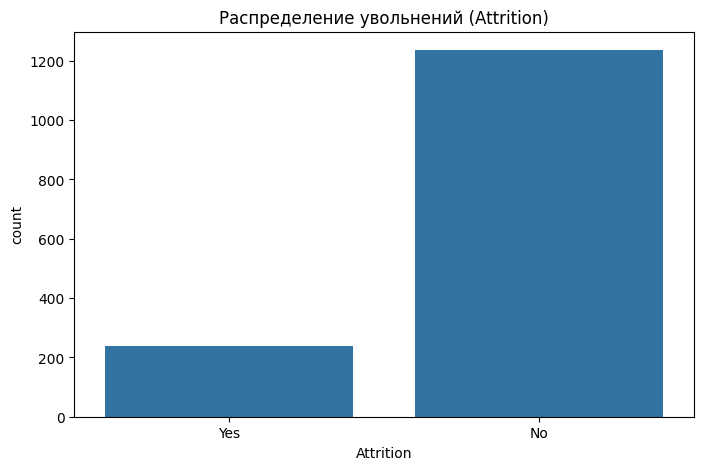


Описательная статистика числовых признаков:
                Age  DistanceFromHome     JobLevel  MonthlyIncome  \
count  1473.000000       1473.000000  1473.000000    1473.000000   
mean     36.917176          9.196877     2.063815    6500.228785   
std       9.130690          8.107754     1.106429    4706.053923   
min      18.000000          1.000000     1.000000    1009.000000   
25%      30.000000          2.000000     1.000000    2911.000000   
50%      36.000000          7.000000     2.000000    4908.000000   
75%      43.000000         14.000000     3.000000    8380.000000   
max      60.000000         29.000000     5.000000   19999.000000   

       PercentSalaryHike  TotalWorkingYears  YearsAtCompany  \
count        1473.000000        1473.000000     1473.000000   
mean           15.212492          11.277665        7.004752   
std             3.657230           7.776228        6.121004   
min            11.000000           0.000000        0.000000   
25%            12.000000  

In [2]:
# Проверка на пропущенные значения
print("\nПропущенные значения:\n", df.isnull().sum())

# Распределение целевой переменной Attrition
plt.figure(figsize=(8, 5))
sns.countplot(x='Attrition', data=df)
plt.title('Распределение увольнений (Attrition)')
plt.show()

# Анализ числовых признаков
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("\nОписательная статистика числовых признаков:\n", df[numerical_cols].describe())

# Анализ категориальных признаков
categorical_cols = df.select_dtypes(include=['object']).columns
print("\nКатегориальные признаки:\n", categorical_cols)
for col in categorical_cols:
    print(f"\nРаспределение для {col}:")
    print(df[col].value_counts())

### 3. Подготовка данных для моделирования

In [3]:
# Кодирование категориальных переменных
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != 'Attrition':  # Целевую переменную обработаем отдельно
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Преобразование целевой переменной
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Выбор признаков и целевой переменной
X = df.drop(['Attrition', 'EmpID'], axis=1)  # Исключаем ID сотрудника
y = df['Attrition']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nРазмер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")
print(f"Баланс классов в обучающей выборке:\n{y_train.value_counts(normalize=True)}")
print(f"Баланс классов в тестовой выборке:\n{y_test.value_counts(normalize=True)}")


Размер обучающей выборки: 1031
Размер тестовой выборки: 442
Баланс классов в обучающей выборке:
Attrition
0    0.838991
1    0.161009
Name: proportion, dtype: float64
Баланс классов в тестовой выборке:
Attrition
0    0.839367
1    0.160633
Name: proportion, dtype: float64


### 4. Обучение модели KNN с произвольным параметром K


Accuracy: 0.834841628959276

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       371
           1       0.43      0.08      0.14        71

    accuracy                           0.83       442
   macro avg       0.64      0.53      0.52       442
weighted avg       0.78      0.83      0.79       442



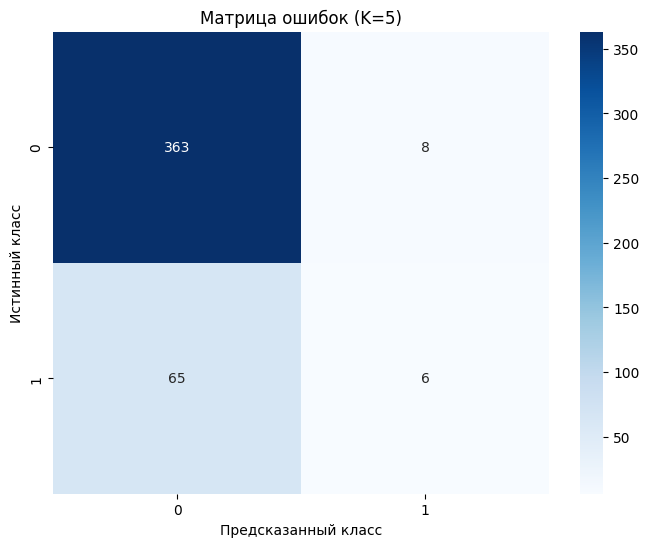

In [4]:
# Создание и обучение модели KNN с K=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Предсказание на тестовых данных
y_pred = knn.predict(X_test_scaled)

# Оценка качества модели
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок (K=5)')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

### 5. Подбор гиперпараметра K с использованием GridSearchCV и RandomizedSearchCV

In [5]:
# Определение параметров для поиска
param_grid = {
    'n_neighbors': np.arange(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Создание моделей поиска
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV с StratifiedKFold
grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=stratified_kfold,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

# RandomizedSearchCV с StratifiedKFold
random_search = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_grid,
    n_iter=20,
    cv=stratified_kfold,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train_scaled, y_train)

# Вывод результатов
print("\nЛучшие параметры (GridSearchCV):", grid_search.best_params_)
print("Лучшая точность (GridSearchCV):", grid_search.best_score_)
print("\nЛучшие параметры (RandomizedSearchCV):", random_search.best_params_)
print("Лучшая точность (RandomizedSearchCV):", random_search.best_score_)


Лучшие параметры (GridSearchCV): {'metric': 'manhattan', 'n_neighbors': np.int64(5), 'weights': 'distance'}
Лучшая точность (GridSearchCV): 0.8535481450213405

Лучшие параметры (RandomizedSearchCV): {'weights': 'distance', 'n_neighbors': np.int64(7), 'metric': 'manhattan'}
Лучшая точность (RandomizedSearchCV): 0.8496740302987664


### 6. Оценка оптимальной модели


Accuracy оптимальной модели: 0.8574660633484162

Classification Report оптимальной модели:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       371
           1       0.68      0.21      0.32        71

    accuracy                           0.86       442
   macro avg       0.77      0.60      0.62       442
weighted avg       0.84      0.86      0.82       442


Accuracy исходной модели (K=5): 0.834841628959276
Accuracy оптимальной модели: 0.8574660633484162


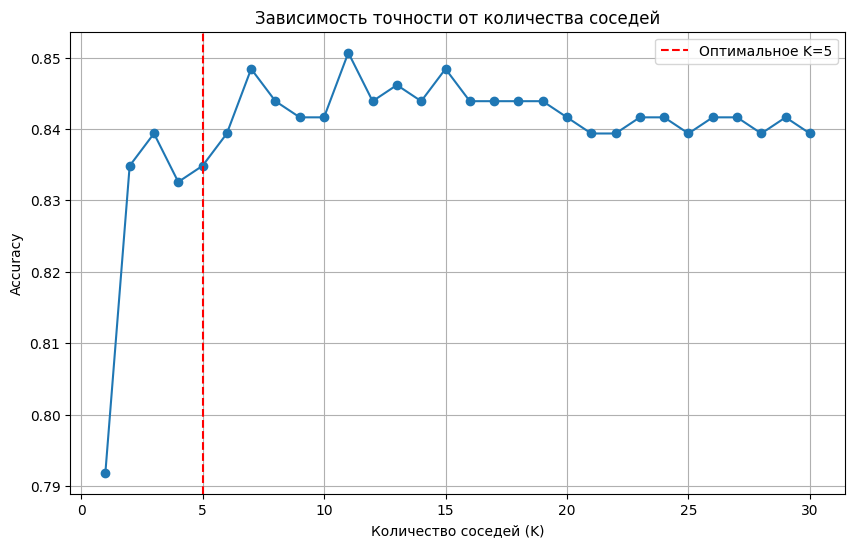

In [6]:
# Лучшая модель
best_knn = grid_search.best_estimator_

# Предсказание на тестовых данных
y_pred_best = best_knn.predict(X_test_scaled)

# Оценка качества оптимальной модели
print("\nAccuracy оптимальной модели:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report оптимальной модели:\n", classification_report(y_test, y_pred_best))

# Сравнение с исходной моделью
print("\nAccuracy исходной модели (K=5):", accuracy_score(y_test, y_pred))
print("Accuracy оптимальной модели:", accuracy_score(y_test, y_pred_best))

# Визуализация точности для разных K
k_values = np.arange(1, 31)
accuracy_scores = []

for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k)
    knn_temp.fit(X_train_scaled, y_train)
    y_pred_temp = knn_temp.predict(X_test_scaled)
    accuracy_scores.append(accuracy_score(y_test, y_pred_temp))

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o')
plt.axvline(x=grid_search.best_params_['n_neighbors'], color='r', linestyle='--', 
            label=f'Оптимальное K={grid_search.best_params_["n_neighbors"]}')
plt.xlabel('Количество соседей (K)')
plt.ylabel('Accuracy')
plt.title('Зависимость точности от количества соседей')
plt.legend()
plt.grid()
plt.show()